# Porsche Competetive Scraper
## Goal: Scrape the App Store for the My Porsche App & Competitors

### Load required libraries

In [3]:
import pandas as pd  
from matplotlib import pyplot as plt  

from itunes_app_scraper.scraper import AppStoreScraper
from app_store_scraper import AppStore

import datetime as dt
from tzlocal import get_localzone

import random
from pprint import pprint
import time
import os
import string
import re

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

import spacy
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tilldratschmidt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!python -m spacy download de_core_news_sm  # download spacy trained pipeline for german language

### Helper functions

In [4]:
def load_app_list():
    """
    Read file that includes all apps that are to be scraped
    """
    df = pd.read_csv("app_list_updated.csv", sep=";")
    df["iOS_app_id"] = df["iOS_app_id"].str.replace("id", "").astype("int")
    return df


def get_general_app_info(app_list_df):
    """
    Take loaded app list as input and return meta information from the
    app store about every app (indicated by app id) in the list.
    """
    scraper = AppStoreScraper()
    app_ids = app_list_df["iOS_app_id"]
    app_meta_info = list(scraper.get_multiple_app_details(app_ids, country="de"))
    app_meta_info_df = pd.DataFrame(app_meta_info)
    return app_meta_info_df


def get_reviews(app_list_df, country_code="de"):
    """
    This function returns a data frame including scraped reviews from the App store.
    Parameters:
    app_list_df - data frame including the app id and name (as displayed in the app store url).
    country_code - 2-digit country code specifiying from which local app store the reviews should be scraped. 
    """
    app_names = app_list_df["iOS_app_name"]
    app_ids = app_list_df["iOS_app_id"]
    
    # gather reviews for each app
    for app_name, app_id in zip(app_names, app_ids):
        
        # get current time
        start_time = dt.datetime.now(tz=get_localzone())
        time_format = "%m/%d/%y - %T %p"
        
        # print starting of scraping app 1,...,n
        print("----"*20)
        print("----"*20)
        print(f"x-x-x-x-x-x {app_name} started at {start_time.strftime(time_format)}")
        
        # initialize AppStore object
        app_ = AppStore(country=country_code, app_name=app_name, app_id=app_id)
        # get ALL reviews available for the app in the countries app store
        app_.review(sleep=random.randint(5, 10))
        
        cur_reviews = app_.reviews
        
        # add meta information to review table
        for review in cur_reviews:
            review["app_name"] = app_name
            review["app_id"] = app_id
            
        # print ending of scraping app 1,...,n
        print(f"Done scraping {app_name}. Scraped {app_.reviews_count} reviews.")
        
        # convert to data frame and write to csv
        review_df = pd.DataFrame(cur_reviews)
        review_df.to_csv("reviews_" + app_name + ".csv", index=False, encoding="utf-8-sig")
        
        # provide finishing message
        end_time = dt.datetime.now(tz=get_localzone())
        print(f"Wrote {app_name} reviews to csv at {end_time.strftime(time_format)}.")
        print(f"Required time for {app_name}: {end_time-start_time}")
        
        # wait a few seconds before starting with the next app
        time.sleep(random.randint(5, 10))

        
def read_and_merge_reviews():
    """
    Returns a data frame that contains all the merged reviews scraped from the app store.
    """
    all_files = os.listdir()
    review_files = [review for review in all_files if "reviews_" in review]
    df = pd.concat(map(pd.read_csv, review_files)).reset_index()
    return df


def add_labels(x, y):
    """
    Add centered labels to plot
    """
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')


def plot_bar_from_group(grouped_data, title, xlabel, ylabel):
    """
    Plot the count of each grouped class in a bar graph.
    """
    cust_dict = {
        "group_label": list(grouped_data.index),
        "count": list(grouped_data.values)
    }
    
    df = pd.DataFrame(cust_dict)
    df = df.sort_values(by="count").reset_index()
    
    plt.figure(figsize=(10,5))
    plt.bar(df["group_label"], df["count"])
    add_labels(df["group_label"], df["count"])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()   
    
    
def convert_to_datetime(date_col):
    """
    Return converted datetime object based on date_col string input.
    """
    out = []
    for date in date_col:
        converted_date = dt.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
        out.append(converted_date)
    
    return out


def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    """
    This function applies lemmatization to the list of reviews passed as input. 
    Lemmatization reduces words to its stem i.e. talked, talking, talk -> talk.
    Additionally, the nlp() basic preprocessing is applied. i.e. lower case, removal of numbers/special characters.
    
    Returns a cleaned/lemmatized list of reviews.
    """
    nlp = spacy.load("de_core_news_sm", disable=["parser", "ner"])  
    texts_out = []
    for text in texts:
        document = nlp(text)
        # iterate over each token in the document
        new_text = []
        for token in document:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        merged_lemma_sentence = " ".join(new_text)
        texts_out.append(merged_lemma_sentence)
    return texts_out


def generate_word_tokens(texts):
    """
    Generates a list of seperated words for each review. Additonally, applies lower case to remove semantic redundancy.
    """
    processed_reviews = []
    for text in texts:
        new_text = gensim.utils.simple_preprocess(text, deacc=True)
        processed_reviews.append(new_text)
    return processed_reviews


def create_dict_and_corpus(data_words):
    """
    Generates: 1. A word dictionary 
               2. A corpus
    """
    # create translation dictionary
    id2word = corpora.Dictionary(data_words)
    # create corpus
    corpus = []
    for review in data_words:
        new_review = id2word.doc2bow(review)
        corpus.append(new_review)
        
    return id2word, corpus



def compute_coherence_score(k_start, k_max, steps, id2word, corpus, text):
    """
    Estimate a LDA model for the range of topics and evaluate its coherence scores.
    """
    coherence_scores = []
    models = []
    for num_topics in range(k_start, k_max, steps):
        cur_lda = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                 id2word=id2word,
                                                 num_topics=num_topics,
                                                 random_state=42,
                                                 update_every=1,
                                                 chunksize=100,
                                                 passes=10,
                                                 alpha="auto")
        models.append(cur_lda)
        coherence_model = CoherenceModel(model=cur_lda, texts=text, dictionary=id2word, coherence="c_v")
        coherence_scores.append(coherence_model.get_coherence())
    return models, coherence_scores



def remove_junk(texts, stops):
    """
    This function takes a review as input and does the following:
    1.) remove german stopwords
    2.) remove punctiation
    3.) remove numbers
    4.) remove unnessary white space
    """
    text = re.sub(r"\d+", "", texts)
    words = texts.split()
    final = []
    for word in words:
        # remove stop words
        if word not in stops:
            final.append(word)
    final = " ".join(final)
    # remove punctuation
    final = final.translate(str.maketrans("", "", string.punctuation))
    # remove numbers
    final = "".join([i for i in final if not i.isdigit()])
    # remove double whitespace
    while "  " in final:
        final = final.replace("  ", " ")
    return final


def clean_document(docs):
    """
    This function applies the remove_junk function to a list of reviews
    """
    stops = stopwords.words("german")
    final = []
    for doc in docs:
        clean_doc = remove_junk(doc, stops)
        final.append(clean_doc)
    return final


def format_topics_sentences(lda_model, corpus, review_df):
    """
    This function returns the review_df data frame with the additinal feaatures of:
    1.) Dominant topic
    2.) Perc. Contribution of Dominant Topic
    3.) Top Keywords Associated to Topic i
    """
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']


    sent_topics_df = pd.concat([sent_topics_df, review_df], axis=1)
    return(sent_topics_df)


def investigate_top_perc_contribution(df):
    """
    Takes the review data frame that includes dominant topic as an input.
    Returns one sentence for each topic that has the highest percentual contibution.
    Thus, gives examples of what sentencs that describe the certain topic look like.
    """
    output = pd.DataFrame()
    grouped_df = df.groupby("Dominant_Topic")
    
    for i, group in grouped_df:
        output = pd.concat([output, group.sort_values(["Perc_Contribution"], ascending=False).head(1)], axis=0)
        
    output.reset_index(drop=True, inplace=True)
    return output


        

### Apply all relevant functions and gather review data

In [ ]:
# load app list
app_list_df = load_app_list()

In [ ]:
app_list_df

In [ ]:
# get meta app information
meta_app_df = get_general_app_info(app_list_df)

In [ ]:
# scrape and write reviews to csv in working directory (Initial Scraping Date: 23.06.2022)
get_reviews(app_list_df, country_code="de")

In [5]:
# load and merge all scraped reviews
review_df = read_and_merge_reviews()

In [6]:
review_df.head()

,index,userName,title,date,isEdited,review,rating,app_name,app_id,developerResponse
0,0,Coli90,Bisher keine größeren Probleme,2020-12-05 05:40:12,False,Die App (auf iPhone SE iOS 14.2) funktioniert ...,4,volkswagen-we-connect,656549103,NaN
1,1,Kpte,An sich sehr gut aber...,2020-10-15 17:36:10,False,An sich ist das echt eine super App. Die ganze...,5,volkswagen-we-connect,656549103,"{'id': 18593922, 'body': 'Lieber Kpte, vielen ..."
2,2,Michael Wenzel,IT Konnektivität,2020-01-25 19:02:26,False,Selbst nach insgesamt 3 1/2 std. Telefonie mit...,5,volkswagen-we-connect,656549103,"{'id': 13180869, 'body': 'Danke für dein Feedb..."
3,3,Ralph-1963,Okay und stabil ...allerdings...,2018-05-20 16:57:32,False,Grundsätzlich macht die App was sie soll. Gege...,4,volkswagen-we-connect,656549103,NaN
4,4,Sohns,App tut was sie soll,2017-10-10 12:38:10,False,Die App läuft bei mir stabil und tut was sie s...,5,volkswagen-we-connect,656549103,NaN


### Exploratory Data Analysis

How many reviews are available in the german App Store per application?

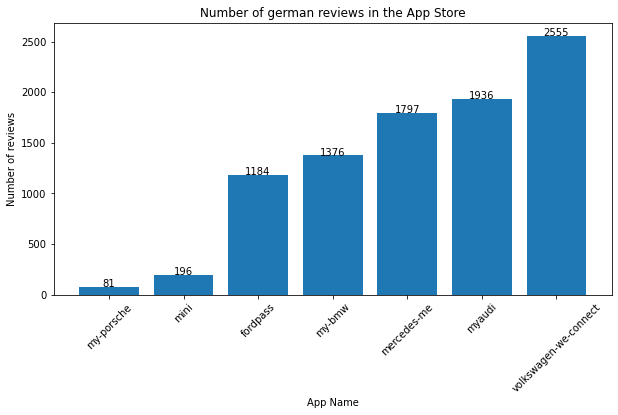

In [7]:
# calculate number of reviews per application
review_count_by_app = review_df.groupby("app_name")["review"].size()

# plot number of reviews per application
plot_bar_from_group(review_count_by_app,
                   title="Number of german reviews in the App Store",
                   xlabel="App Name",
                   ylabel="Number of reviews")

What is the average rating per app?
<p>Important finding: Average ratings and number of reviews displayed in the App Store represent global submissions.
However, when we narrow down to the german market only, we obtain a differrent picture.
The number and average rating of the My Porsche App was verified by visting the German App Store and manually scanning the reviews. Thus, for all of the apps, we observe a worse satisfaction level in Germany, compared to the global perception.

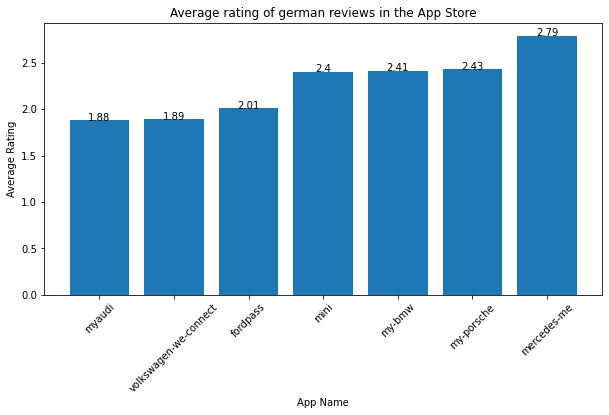

In [8]:
# calculate average rating by application
average_rating_by_app = review_df.groupby("app_name")["rating"].mean().round(2)

# plot average rating per application
plot_bar_from_group(average_rating_by_app,
                   title="Average rating of german reviews in the App Store",
                   xlabel="App Name",
                   ylabel="Average Rating")

How are the ratings distributed by app?

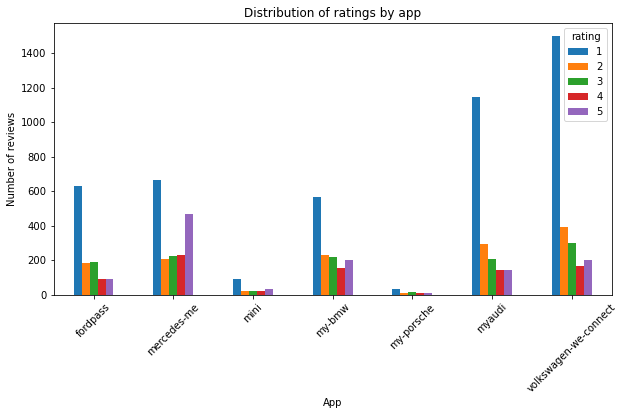

In [9]:
# plot rating distribution by app
ax = (review_df[["app_name", "rating"]].groupby(['app_name','rating'])
   .value_counts().unstack('rating').plot.bar(figsize=(10,5), rot=45))
ax.set_xlabel("App")
ax.set_ylabel("Number of reviews")
ax.set_title("Distribution of ratings by app")
plt.show()

How many reviews did users submit over time?

In [10]:
# convert date feature to datetime object
review_df["date"] = convert_to_datetime(review_df["date"])

In [11]:
# add a year-month column
review_df["year_month"] = review_df["date"].dt.to_period("M")

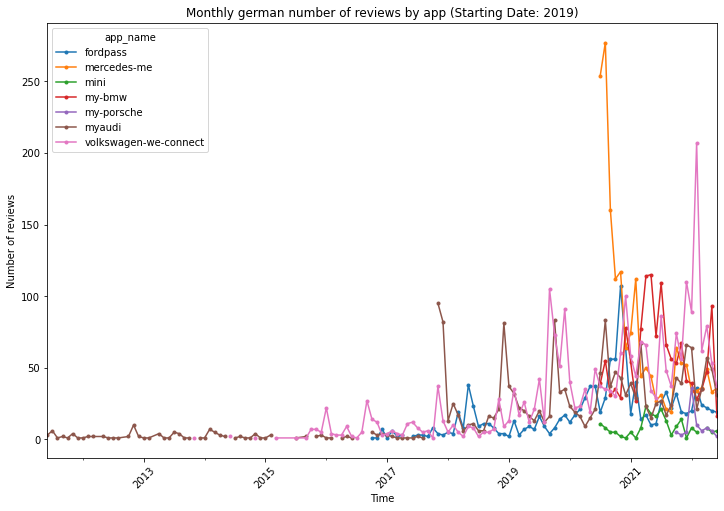

In [12]:
# Plot monthly number of reviews by app
ax = (review_df[["app_name", "year_month"]].groupby(['app_name','year_month'])
   .value_counts().unstack('app_name').plot(figsize=(12,8), rot=45, style=".-"))
ax.set_xlabel("Time")
ax.set_ylabel("Number of reviews")
ax.set_title("Monthly german number of reviews by app (Starting Date: 2019)")
plt.show()

## Text preprocessing

In [13]:
# sample equal number of reviews per app (with same rating weight as observed in full set)
review_subset = review_df.groupby("app_name").apply(lambda x: x.sample(80, random_state=666, weights=review_df.groupby('app_name')["rating"].transform('count'))).reset_index(drop=True)

In [14]:
review_subset.head()

,index,userName,title,date,isEdited,review,rating,app_name,app_id,developerResponse,year_month
0,829,Poldi von Pösel,Das letzte Update war wohl nix.,2018-03-16 09:04:46,False,Das letzte Update war mal wieder ein Satz mit ...,1,fordpass,1141464928,"{'id': 3131365, 'body': 'Wir bedauern das Sie ...",2018-03
1,999,brother_of_zoigl,Funktioniert nicht sowie es soll,2020-12-03 13:20:01,False,Darüber kann man viele viele Seiten im Netz le...,1,fordpass,1141464928,"{'id': 19549829, 'body': 'Hallo brother_of_zoi...",2020-12
2,800,Julez182,Absturz,2022-03-15 07:35:42,False,Ich fand die App bis jetzt immer gut. Seit ein...,2,fordpass,1141464928,"{'id': 28614082, 'body': 'Hallo Julez182, wir ...",2022-03
3,861,Max40plus,Katastrophe,2020-11-19 15:20:58,False,"Eines großen Herstellers unwürdig! Langsam, si...",1,fordpass,1141464928,"{'id': 19262674, 'body': 'Hallo Max40plus, wir...",2020-11
4,1126,Thoklar,"App mit nützlichen Funktionen, saugt aber zu v...",2020-11-24 17:00:13,True,Update 24.11.2020: ich habe die App in den ver...,2,fordpass,1141464928,"{'id': 18231635, 'body': 'Hallo Thoklar, wir f...",2020-11


In [15]:
# compare average rating with average rating of full data
review_subset.groupby("app_name")["rating"].mean().round(2)

app_name
fordpass                 2.15
mercedes-me              2.79
mini                     2.51
my-bmw                   2.58
my-porsche               2.40
myaudi                   2.08
volkswagen-we-connect    1.82
Name: rating, dtype: float64

In [16]:
# verify 560 total observations (80*n_brands)
review_subset.shape

(560, 11)

In [17]:
# apply lemmatization (reduce word to its root-stem)
lemmatized_reviews = lemmatization(review_subset["review"])  # exchange review_subset with review_df["review"] to get full data as model input
# apply custom text cleaning
lemmatized_reviews = clean_document(lemmatized_reviews) 

In [18]:
# tokenization
data_words = generate_word_tokens(lemmatized_reviews)

In [19]:
data_words[0][0:10]

['letzter',
 'update',
 'mal',
 'satz',
 'usbverbindung',
 'sturzen',
 'app',
 'immer',
 'irgendwann',
 'klappen']

In [20]:
# create index to word dictionary (required for LDA modeling)
id2word, corpus = create_dict_and_corpus(data_words)

In [21]:
# List of tuples: (i, j) -> i = index of word in dictionary, j = frequency of word at index i
print(corpus[0][0:10])
print(f"Word of first tuple: {id2word[[0][:1][0]]}")

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1)]
Word of first tuple: app


## Additional Preprocessing - TF-IDF

In [22]:
# create new id2word dictionay and corpus based on bi/trigram tokenized data
id2word_iter = corpora.Dictionary(data_words)
texts_iter = data_words
corpus_iter = [id2word_iter.doc2bow(text) for text in texts_iter]

In [23]:
# initialize TF-IDF object (goal: exclude overly-used/non specific words)
tfidf = TfidfModel(corpus_iter, id2word_iter)

low_value = 0.05
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus_iter)):
    bow = corpus_iter[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word_iter[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus_iter[i] = new_bow

In [24]:
# get unique list of words to be filtered out
unique_words_filter_out = set(words)

In [25]:
print(unique_words_filter_out)

{'kommen', 'fahrzeug', 'geben', 'gehen', 'moglich', 'gut', 'schon', 'auto', 'installieren', 'funktion', 'neu', 'mehr', 'funktionieren', 'app', 'mal', 'immer', 'leider', 'nutzen'}


In [26]:
# remove threhold words
removed_tfidf_reviews = []
for review in data_words:
    cur_review = review
    updated_review = [word for word in cur_review if word not in unique_words_filter_out]
    removed_tfidf_reviews.append(updated_review)

In [27]:
id2word_updated = corpora.Dictionary(removed_tfidf_reviews)
corpus_updated = [id2word_updated.doc2bow(text) for text in removed_tfidf_reviews]

In [29]:
# estimate LDA with abitrary number of topic to see if it works on processed data. In this case 8
lda_model_after_tfidf_removal = gensim.models.ldamodel.LdaModel(corpus=corpus_updated,
                                                               id2word=id2word_updated,
                                                               num_topics=8,
                                                               random_state=42,
                                                               update_every=1,
                                                               chunksize=100,
                                                               passes=10,
                                                               alpha="auto")

In [63]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model_after_tfidf_removal, corpus_updated, id2word_updated, mds="mmds", R=30)

/opt/anaconda3/envs/wwu_da2/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/envs/wwu_da2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/wwu_da2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/wwu_da2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/wwu_da2/lib/pytho

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.009870  0.317672       1        1  21.977261
0      0.005313 -0.319798       2        1  18.200430
2     -0.285210 -0.060156       3        1  12.964847
4     -0.198939  0.156955       4        1  12.829527
7      0.216211 -0.150692       5        1  10.311961
1      0.185129  0.009451       6        1   8.291751
3      0.162579  0.155317       7        1   8.289606
6     -0.075214 -0.108749       8        1   7.134616, topic_info=                Term       Freq      Total Category  logprob  loglift
215       verbindung  39.000000  39.000000  Default  30.0000  30.0000
204              alt  67.000000  67.000000  Default  29.0000  29.0000
222           fehlen  34.000000  34.000000  Default  28.0000  28.0000
686     standheizung  39.000000  39.000000  Default  27.0000  27.0000
464          einfach  37.000000  37.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
2062           login   7.147514  17.100563   Topic8  -4.3858   1.7679
70          anmelden   7.473410  21.747321   Topic8  -4.3412   1.5721
631          schnell   4.741374  12.698389   Topic8  -4.7963   1.6551
254   funktionierend   2.839364   7.188738   Topic8  -5.3090   1.7113
300            stern   2.731467  19.093959   Topic8  -5.3478   0.6957

[372 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2417      2  0.924413     ablaufen
858       1  0.912356   abschalten
542       3  0.912972      absolut
33        6  0.957546         akku
2309      6  0.857328       aktion
...     ...       ...          ...
1655      5  0.951665     zuordnen
731       3  0.905582       zuruck
407       5  0.775002   zusatzlich
177       4  0.800391  zuverlassig
177       5  0.200098  zuverlassig

[435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 5, 8, 2, 4, 7])

In [30]:
# Calculate coherence score:
coherence_model_lda = CoherenceModel(model=lda_model_after_tfidf_removal, 
                                     texts=data_words, 
                                     dictionary=id2word_updated, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4017366922221329


## Find optimal number of topics

In [31]:
# initialize topic space
k_start = 2
k_max = 20
steps = 2

In [32]:
start = time.time()
models, coherence_scores = compute_coherence_score(k_start=k_start, 
                                                   k_max=k_max, 
                                                   steps=steps, 
                                                   id2word=id2word_updated, 
                                                   corpus=corpus_updated,
                                                   text=data_words)
end = time.time()
print(end-start)

28.422411680221558


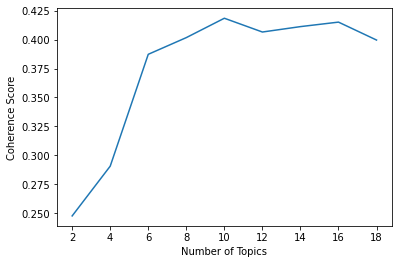

In [33]:
# plot coherence scores
x = list(range(k_start, k_max, steps))
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [34]:
# get coherence scores
for topic_number, coherence in zip(x, coherence_scores):
    print("Num Topics =", topic_number, " has Coherence Value of", round(coherence, 4))

Num Topics = 2  has Coherence Value of 0.2476
Num Topics = 4  has Coherence Value of 0.2906
Num Topics = 6  has Coherence Value of 0.3873
Num Topics = 8  has Coherence Value of 0.4017
Num Topics = 10  has Coherence Value of 0.4185
Num Topics = 12  has Coherence Value of 0.4066
Num Topics = 14  has Coherence Value of 0.4112
Num Topics = 16  has Coherence Value of 0.4151
Num Topics = 18  has Coherence Value of 0.3996


Although a larger number of topics is prefered as indicated by the coherence score. We opt for n_topics = 10 due to elbow criterion.

## Final LDA Model with n_topics = 10

In [68]:
final_lda = gensim.models.ldamodel.LdaModel(corpus=corpus_updated,
                                                               id2word=id2word_updated,
                                                               num_topics=10,
                                                               random_state=42,
                                                               update_every=1,
                                                               chunksize=100,
                                                               passes=10,
                                                               alpha="auto")

In [69]:
# IMPORTANT NOTE: LDAvis Topic numbering does NOT correspond to actual Topic numbering (see below for accurate.)
# This is just an interactive view on how destinguishable the topics are
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(final_lda, corpus_updated, id2word_updated, mds="mmds", R=30)

/opt/anaconda3/envs/wwu_da2/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.046603  0.352153       1        1  22.138341
0      0.020762 -0.353120       2        1  18.052449
7     -0.309771 -0.092302       3        1  13.999577
3     -0.233553  0.162421       4        1  13.006900
4      0.240046 -0.163611       5        1   8.258097
1      0.241118  0.016715       6        1   7.604783
9      0.190158  0.205685       7        1   5.708683
2     -0.109031 -0.172875       8        1   5.673579
8     -0.050371  0.010815       9        1   2.855278
6      0.057246  0.034119      10        1   2.702312, topic_info=                Term       Freq      Total Category  logprob  loglift
204              alt  71.000000  71.000000  Default  30.0000  30.0000
7             update  41.000000  41.000000  Default  29.0000  29.0000
222           fehlen  39.000000  39.000000  Default  28.0000  28.0000
229            warum  37.000000  37.000000  Default  27.0000  27.0000
59           problem  36.000000  36.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
2228           drauf   1.170804   1.818633  Topic10  -5.2241   3.1707
361       aktivieren   2.925263   8.823778  Topic10  -4.3084   2.5070
81              erst   4.848537  21.754419  Topic10  -3.8031   2.1099
56            mussen   2.200809   6.593220  Topic10  -4.5929   2.5138
2227  deinstallation   1.836820   4.605204  Topic10  -4.7737   2.6919

[430 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2458     10  0.933574       abbruch
2465     10  0.512196  abgasskandal
2417      3  0.926440      ablaufen
858       1  0.918304    abschalten
542       8  0.896328       absolut
...     ...       ...           ...
986       4  0.820577     zufrieden
107       7  0.922414       zugriff
731       5  0.970277        zuruck
2577     10  0.512185         zutun
177       5  0.947896   zuverlassig

[480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 8, 4, 5, 2, 10, 3, 9, 7])

In [ ]:
# Word Cloud of keywords in Topics (https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)
# 1. Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords.words("german"),
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = final_lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(13,13), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

/var/folders/hf/xf08fd0s10g31gp463s5w6qw0000gn/T/ipykernel_71161/896155026.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/hf/xf08fd0s10g31gp463s5w6qw0000gn/T/ipykernel_71161/896155026.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/hf/xf08fd0s10g31gp463s5w6qw0000gn/T/ipykernel_71161/896155026.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/hf/xf08fd0s10g31gp463s5w6qw0000gn/T/ipykernel_71161/896155026.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignmen

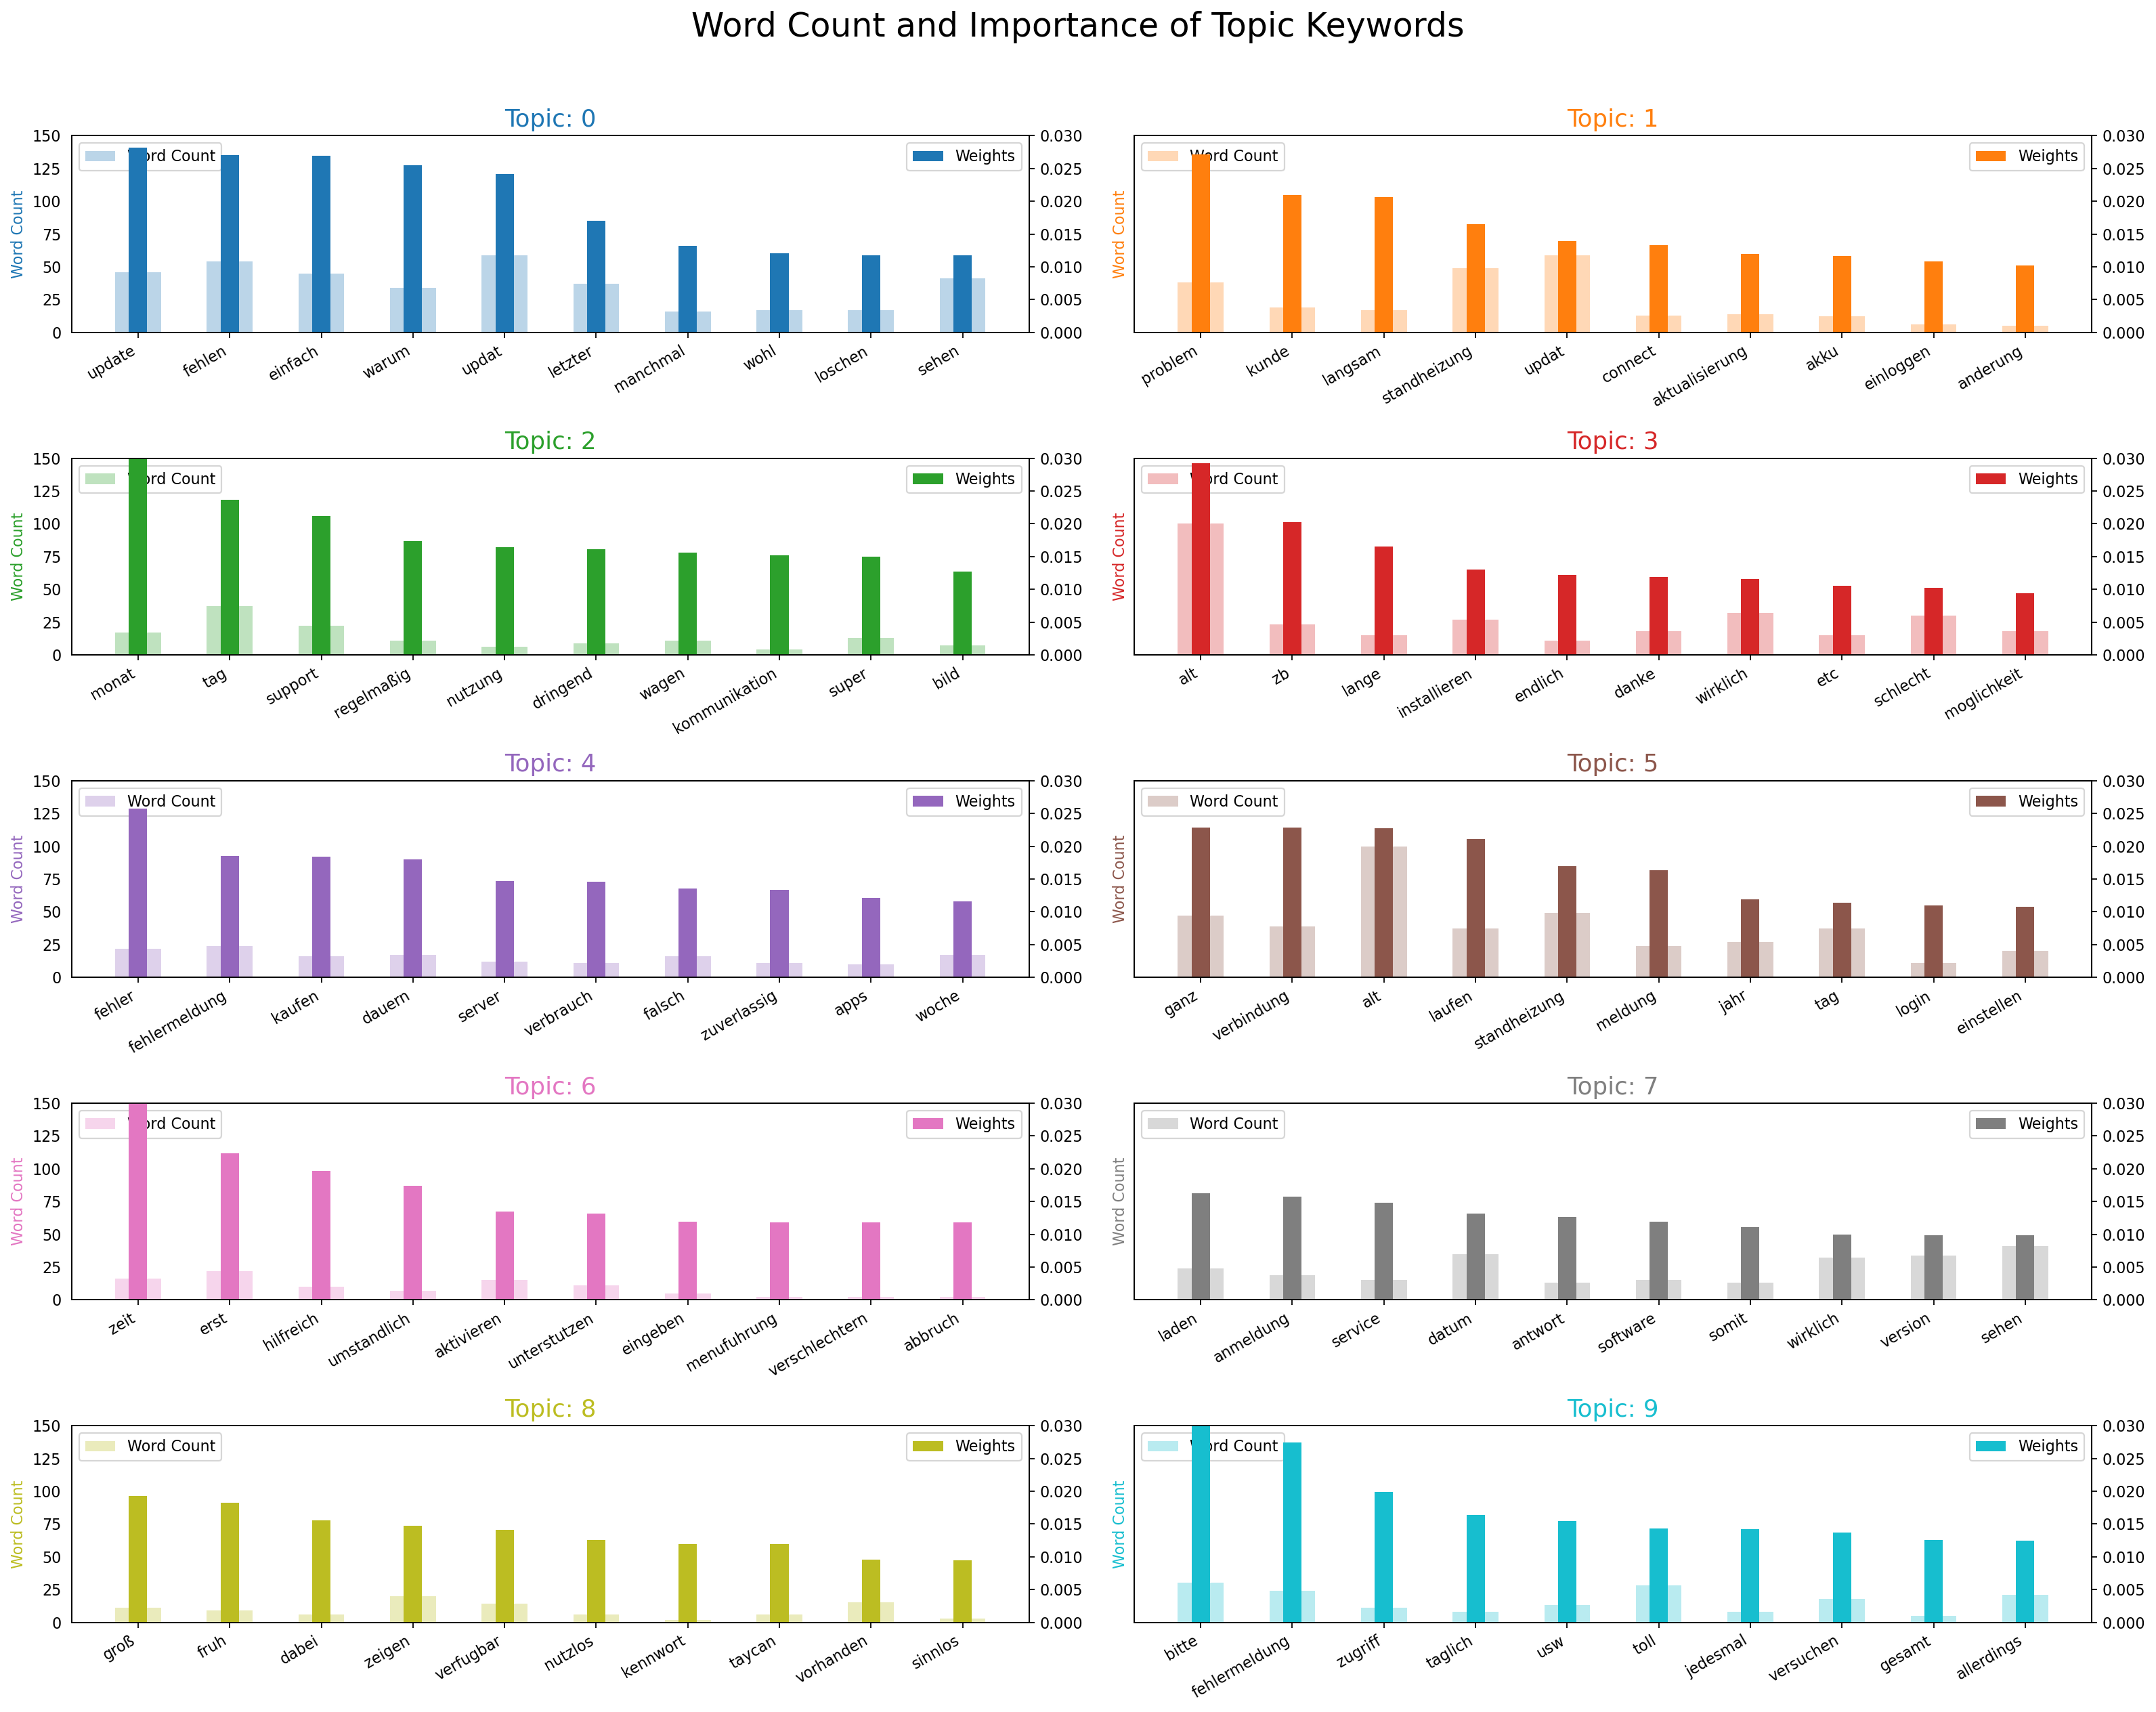

In [110]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#19findthemostrepresentativedocumentforeachtopic
# Visalize top keywords

from collections import Counter
topics = final_lda.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(20,15), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 150)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Naming Topics (Subjective but whatever :D):
Takes into consideration the wordcloud/frequency as well as the LDAvis output that shows top 30 relevant keywords.
- <b> Topic 0 </b>
<p>Missing Updates
- <b> Topic 1 </b>
<p> Connectivity Issues
- <b> Topic 2 </b>
<p> Time-based Support    
- <b> Topic 3 </b>
<p> Legacy Systems
- <b> Topic 4 </b>
<p> Application Error
- <b> Topic 5 </b>
<p>Legacy Connectivity
- <b> Topic 6 </b>
<p> Useability and Activation
- <b> Topic 7 </b>
<p> Loading and Login Service    
- <b> Topic 8 </b>
<p> Feature Availibility
- <b> Topic 9 </b>
<p> Access Error Support Request

## Find the dominant topic in each review

In [74]:
df_with_topics = format_topics_sentences(final_lda, corpus_updated, review_subset)  # exchange review_subset with review_df for entire data!

/var/folders/hf/xf08fd0s10g31gp463s5w6qw0000gn/T/ipykernel_71161/2847047730.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/hf/xf08fd0s10g31gp463s5w6qw0000gn/T/ipykernel_71161/2847047730.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [116]:
name_dictionary = {0: "Missing Update",
                  1:  "Connectivity Issue",
                  2:  "Time-based Support",
                  3:  "Legacy Systems",
                  4:  "Application Error",
                  5:  "Legacy Connectivity", 
                  6:  "Usability & Activation",
                  7:  "Loading & Login Service",
                  8:  "Feature Availibility",
                  9:  "Access Error Support Request"}

def add_topic_name(name_dictionary, df):
    topic_name = []
    for topic_number in df["Dominant_Topic"]:
        topic_name.append(name_dictionary.get(topic_number))
    
    topic_name = pd.Series(topic_name)
    return topic_name
    
    
df_with_topics["Topic_Name"] = add_topic_name(name_dictionary, df_with_topics)    

In [118]:
df_with_topics.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,index,userName,title,date,isEdited,review,rating,app_name,app_id,developerResponse,year_month,Topic_Name
0,0,0.4277,"update, fehlen, einfach, warum, updat, letzter...",829,Poldi von Pösel,Das letzte Update war wohl nix.,2018-03-16 09:04:46,False,Das letzte Update war mal wieder ein Satz mit ...,1,fordpass,1141464928,"{'id': 3131365, 'body': 'Wir bedauern das Sie ...",2018-03,Missing Update
1,3,0.5880,"alt, zb, lange, installieren, endlich, danke, ...",999,brother_of_zoigl,Funktioniert nicht sowie es soll,2020-12-03 13:20:01,False,Darüber kann man viele viele Seiten im Netz le...,1,fordpass,1141464928,"{'id': 19549829, 'body': 'Hallo brother_of_zoi...",2020-12,Legacy Systems
2,5,0.6107,"ganz, verbindung, alt, laufen, standheizung, m...",800,Julez182,Absturz,2022-03-15 07:35:42,False,Ich fand die App bis jetzt immer gut. Seit ein...,2,fordpass,1141464928,"{'id': 28614082, 'body': 'Hallo Julez182, wir ...",2022-03,Legacy Connectivity
3,8,0.6480,"groß, fruh, dabei, zeigen, verfugbar, nutzlos,...",861,Max40plus,Katastrophe,2020-11-19 15:20:58,False,"Eines großen Herstellers unwürdig! Langsam, si...",1,fordpass,1141464928,"{'id': 19262674, 'body': 'Hallo Max40plus, wir...",2020-11,Feature Availibility
4,1,0.7042,"problem, kunde, langsam, standheizung, updat, ...",1126,Thoklar,"App mit nützlichen Funktionen, saugt aber zu v...",2020-11-24 17:00:13,True,Update 24.11.2020: ich habe die App in den ver...,2,fordpass,1141464928,"{'id': 18231635, 'body': 'Hallo Thoklar, wir f...",2020-11,Connectivity Issue


In [79]:
set(df_with_topics["Dominant_Topic"])  # 0 -> Topic 1 etc. Apparently topic 2 is NOT the most dominant in any case.

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Plot distribution of Topics by App

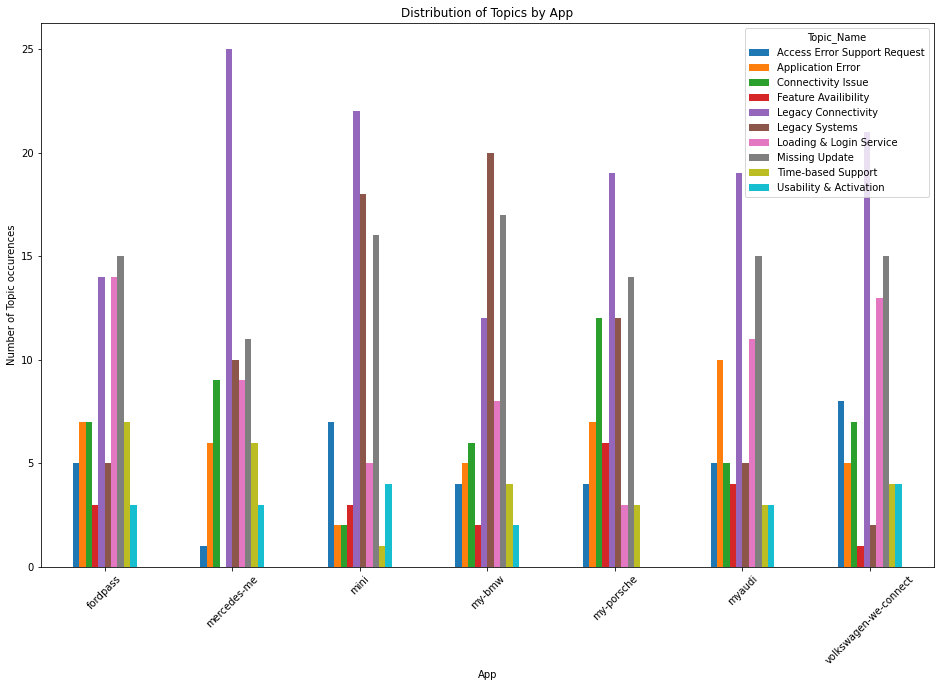

In [121]:
# plot rating distribution by app
ax = (df_with_topics[["app_name", "Topic_Name"]].groupby(['app_name','Topic_Name'])
   .value_counts().unstack('Topic_Name').plot.bar(figsize=(16,10), rot=45))
ax.set_xlabel("App")
ax.set_ylabel("Number of Topic occurences")
ax.set_title("Distribution of Topics by App")
plt.show()

### What is the average rating by app and Topic. Do some apps perform better within certain categories?


In [ ]:
# TBD!

In [ ]:
# output percentual topic probabilities per review (one list entry = 1 review)
for i, row in enumerate(final_lda[corpus_updated]):
    row = sorted(row, key=lambda x:x[1], reverse=True)
    print(row)

In [85]:
# extract top sentences that have a high percentual contribution in the corresponding topic
top_sentences = investigate_top_perc_contribution(df_with_topics)

In [91]:
# display exemplary sentneces for each topic (+1 index)
for index, review in enumerate(top_sentences["review"]):
    print(f"Topic {index+1}:\n {review}")
    print("----------")

Topic 1:
 Sie schreiben:

So starten Sie Fuel & Pay:
„...Um den Dienst nutzen zu können, gehen Sie einfach in Ihre Mercedes me App, aktivieren Sie den Dienst „Tanken digital bezahlen“ einmalig und hinterlegen Sie - falls noch nicht erfolgt Ihre Bezahldaten...“

Warum beschreiben Sie nicht eindeutig, wo diese Dienstaktivierung versteckt ist?

Links oben 3-Strich Hauptmenü:

- Auf Fahrzeug klicken, dann taucht die sogenannte Garage wie aus dem Nichts auf.

- Dort auf Diensteverwaltung klicken

- Dienste aktivieren oder deaktivieren.
😛

Ich hasse es, wenn Entwickler die Geduld der User auf die Probe stellen.

Warum machen Sie das nur?
----------
Topic 2:
 Die Aktivierung der Standheizung funktioniert nach Update der App erneut nicht. 
Eine andere Art die Standheizung einzuschalten gibts aber nicht. 
Man kann sein Fahrzeug also nicht vollumfänglich nutzen. 👎🏻
----------
Topic 3:
 Habe mein neues Auto nun einen Monat und die App lässt es nicht zu meinen Wagen hinzuzufügen. Habe den Support 

## Try TF-IDF and KMeans approach to cluster short text into topics

In [93]:
# apply cleaning functions to raw text reviews
clean_reviews = clean_document(lemmatized_reviews)  # basically redundant as already performed earlier

In [96]:
vectorizer = TfidfVectorizer(lowercase=True,
                            max_features=100,
                            max_df=0.75,  # words that occur at greater than 75% in the corpus are ignored
                            min_df=5,  # if a word does not occur at least 5 times, ignore it
                            ngram_range=(1,3))

In [97]:
# apply TF-IDF
vectors = vectorizer.fit_transform(clean_reviews)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

all_keywords = []
for description in denselist:
    x = 0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x += 1
    all_keywords.append(keywords)

/opt/anaconda3/envs/wwu_da2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [98]:
print(all_keywords[0])
print("--------")
print(clean_reviews[0])  # altered for TF-IDF approach --> Keywords of the revieew

['app', 'immer', 'klappen', 'letzter', 'mal', 'update', 'vielleicht']
--------
letzter Update mal Satz X USBVerbindung stürzen App immer irgendwann klappen vielleicht mal enttäuscht AppNutzer


## Cluster the list of keywords based on TF-IDF by KMeans

In [99]:
# find optimal number of clusters (initially using the elbow criterion)
distortions = []
K = range(1, 20)
for k in K:
    kmean_model = KMeans(n_clusters=k, init="k-means++", max_iter=100, n_init=1)
    kmean_model.fit(vectors)
    distortions.append(kmean_model.inertia_)

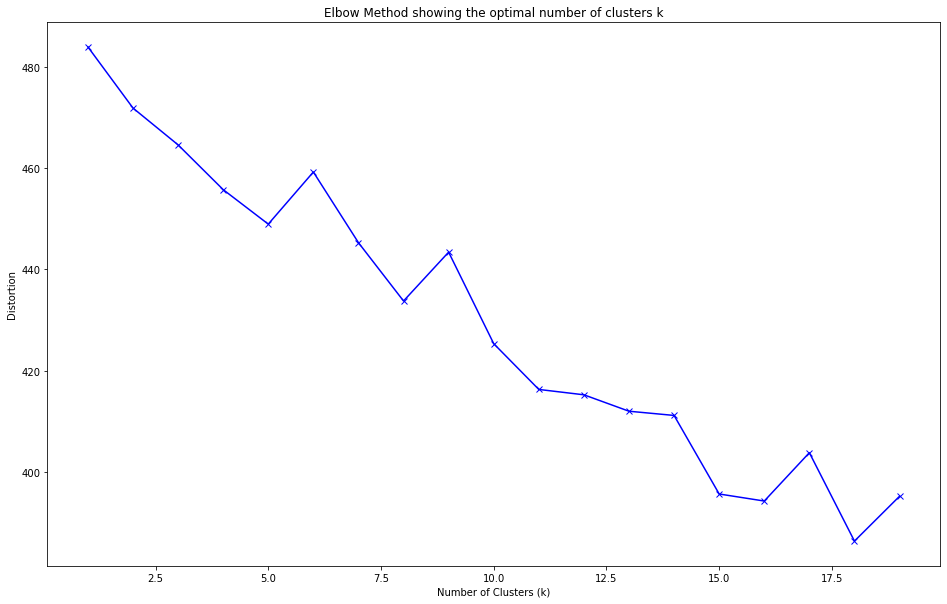

In [100]:
# plot distortions = sum of squared distance between each observation vector
plt.figure(figsize=(16,10))
plt.plot(list(K), distortions, "bx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion")
plt.title("Elbow Method showing the optimal number of clusters k")
plt.show()

Based on this we can conclude that K = 10 is the seems appropriate.

In [101]:
# fit final Kmeans with k = 10
final_kmeans = KMeans(n_clusters=10,
                     init="k-means++",
                     max_iter=100,
                     n_init=1)
final_kmeans.fit(vectors)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [102]:
# extract information
order_centroids = final_kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

/opt/anaconda3/envs/wwu_da2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [103]:
# print topic keywords that are associated with each cluster
for i in range(8):
    print(f"Cluster {i}")
    print("\n")
    for ind in order_centroids[i, :15]:
        print(" %s" %terms[ind],)
    print("\n")
    print("\n")

Cluster 0


 funktionieren
 app
 app funktionieren
 mehr
 fahrzeug
 schlecht
 einfach
 leider
 gut
 gar
 auto
 ja
 öffnen
 ganz
 funktion




Cluster 1


 immer
 app
 funktionieren
 leider
 fahrzeug
 nutzen
 neu
 gut
 updat
 geben
 alt
 schade
 fehler
 woche
 auto




Cluster 2


 komplett
 ja
 zb
 erst
 anmelden
 updat
 geben
 app
 immer
 mal
 auto
 gut
 neu
 funktionieren
 jahr




Cluster 3


 einstellen
 starten
 bitte
 neu app
 einfach
 fehlen
 funktion
 neu
 app
 fehler
 fehlermeldung
 fenster
 finden
 funktionieren
 überhaupt




Cluster 4


 sehen
 schön
 funktion
 updat
 fehlen
 leider
 app
 mehr
 schade
 neu
 auto
 letzter
 standheizung
 funktionieren
 immer




Cluster 5


 app
 fahrzeug
 schon
 neu
 stern
 starten
 auto
 datum
 alt app
 kommen
 nutzen
 komplett
 laden
 alt
 updat




Cluster 6


 mal
 app
 funktionieren
 anzeigen
 richtig
 gut
 leider
 tag
 neu
 ganz
 zeigen
 oft
 funktion
 überhaupt
 vielleicht




Cluster 7


 mehr
 update
 letzter
 app
 app mehr
 updat
 

In comparison to the LDA approach, topic modelling with TFIDF and KMeans does not seem to yield interpretable results. Furthmore, we observe a even greater topic overlap in comparison to the LDA soltution. Thus, we consider the LDA approach more feasible for the final interpretation.

In [35]:
# TBC
print("------")

------
